In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.core.callback import Callback
from pymoo.problems import get_problem
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize

In [2]:
problem = get_problem("ackley", n_var=2)

class CustomCallback(Callback):
    def __init__(self, n_gen):
        super().__init__()
        # tqdmプログレスバーを初期化
        self.pbar = tqdm(total=n_gen, desc="Evolving")
        # 各世代の統計データを格納するための辞書を初期化
        self.data = {
            "avg": [],
            "min": [],
            "std": []
        }

    def notify(self, algorithm):
        # 現在の世代の集団の適応度を取得
        pop_f = algorithm.pop.get("F")
        
        # 統計データを記録
        self.data["avg"].append(np.mean(pop_f))
        self.data["min"].append(np.min(pop_f))
        self.data["std"].append(np.std(pop_f))

        # プログレスバーを1ステップ進める
        self.pbar.update(1)

    def __del__(self):
        # 実行終了時にプログレスバーを閉じる
        self.pbar.close()


# 100世代で計算を終了するように設定
termination = ("n_gen", 250)

algorithm = DE(
    pop_size=100,
    sampling=LHS(),
    variant="DE/rand/1/bin",
    CR=0.3,
    dither="vector",
    jitter=False
)

In [3]:
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               callback=CustomCallback(termination[1]),
               verbose=False)

Evolving:   0%|          | 0/250 [00:00<?, ?it/s]

Evolving:  99%|█████████▉| 247/250 [00:02<00:00, 89.50it/s] 


-- End of evolution --
individual: [ 6.47052221e-17 -2.41987555e-16]
fitness: 4.440892098500626e-16


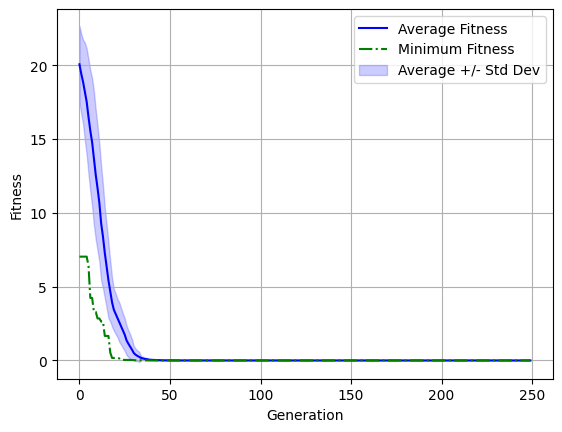

Evolving: 100%|██████████| 250/250 [00:19<00:00, 89.50it/s]

In [ ]:
# --- 5. 結果の表示 ---
# deapでの hof[0] や hof[0].fitness.values に相当します。
print("\n-- End of evolution --")
print(f"individual: {res.X}")
print(f"fitness: {res.F[0]}")

# --- 6. グラフの描画 ---
# Callbackオブジェクトから統計データを直接取得してグラフを作成します。
callback_data = res.algorithm.callback.data
avg_list = np.array(callback_data["avg"])
min_list = np.array(callback_data["min"])
std_list = np.array(callback_data["std"])
n_gen = len(min_list)

gen = np.arange(n_gen)
#fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
fig, ax = plt.subplots()

# mean with solid line
line1 = ax.plot(gen, avg_list, "b-", label="Average Fitness")

# min with dashed line
line2 = ax.plot(gen, min_list, "g-.", label="Minimum Fitness")

ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

# 平均 +/- 標準偏差の範囲を塗りつぶしで表示
std_upper = avg_list + std_list
std_lower = avg_list - std_list
ax.fill_between(gen, std_lower, std_upper,
                 color='b', alpha=0.2, label="Average +/- Std Dev")

ax.legend(loc="upper right")
plt.grid(True)
plt.show()